In [2]:
# Packages

# general
import pandas as pd

# finviz data 
from bs4 import BeautifulSoup as bs
import requests

# Scale Data
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Plot
import matplotlib.pyplot as plt
import numpy as np

In [165]:
# Packages


def fundamental_metric(soup, metric):
    return soup.find(text = metric).find_next(class_='snapshot-td2').text

def get_fundamental_data(df):
    for symbol in df.index:
        try:
            url = ("http://finviz.com/quote.ashx?t=" + symbol.lower())
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}
            soup = bs(requests.get(url, headers=headers).content)
            for m in df.columns:
                df.loc[symbol, m ] = fundamental_metric(soup, m)
        except Exception as e:
            print(symbol, 'not found')
    return df

#############################
# Select Stocks and Metrics #
#############################
stock_list = [
    'FB', 'AMZN', 'AAPL', 'MSFT', 'GOOG',
    'PG',
    'KO',
    'IBM',
    'DG',
    'XOM',
    'PEP', 
    'DKS', 
    'RTX',
    'BRK-A', 'BRK-B',
    'JPM', 'BA',
    'BAC',
    'AA',
    'GOLD',
    'AAP',
    'ADBE',
    'ANTHM',
    'AZO',
    'BGS',
    'BIG',
    'BOOT',
    'BTI',
    'BXG',
    'C',
    'CAJ',
    'CALM',
    'CI',
    'COKE',
    'CTB',
    'DELL',
    'DG',
    'DFS',
    'DGX',
    'EA',
    'EBAY',
    'FOX',
    'FOXA',
    'FOXF',
    'GD',
    'HOG',
    'HON',
    'HPE',
    'HPQ',
    'KR',
    'LMT',
    'MET',
    'MS'
    ]

metric = ['Price',
'P/B',
'P/E',
'P/S',
'P/C',
'P/FCF',
'Forward P/E',
'PEG',
'Debt/Eq',
'EPS (ttm)',
'Dividend %',
'ROE',
'ROI',
'EPS Q/Q',
'Insider Own'
]

df = pd.DataFrame(index = stock_list, columns = metric)
df = get_fundamental_data(df)

for char in ["%", " ", "/"]:
    df.columns = df.columns.str.replace(char, "")

for col in ['Dividend', 'ROE', 'ROI', 'EPSQQ', 'InsiderOwn']:
    df[col] = df[col].str.replace("%", '')
df = df.apply(pd.to_numeric, errors='coerce')

ANTHM not found


In [185]:
#########################
# Select and Scale Data #
#########################
# Select Data
features = [
    # 'PE', 
    'PB',
    # 'PC',
    'PS',
    'Dividend',
    # 'PFCF',
    # 'ForwardPE',
    'InsiderOwn',
    # 'EPS(ttm)', 
    # 'EPSQQ'
    'ROI',  
    'ROE'
    ]
finvals = df

# Remove non numeric values
finvals = finvals[~finvals[features].isin([np.nan, np.inf, -np.inf]).any(1)]

# Select Valvues
feature_values = finvals.loc[:, features].values 

# Scale Values
scaled_values = StandardScaler().fit_transform(feature_values)

In [186]:
finvals.shape

(35, 15)

<function matplotlib.pyplot.show(close=None, block=None)>

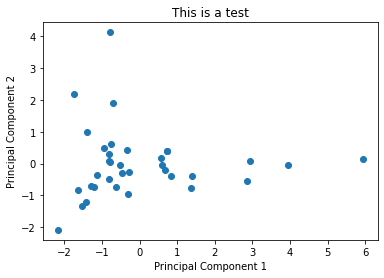

In [187]:
#######
# PCA #
#######
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_values)
principal_df = pd.DataFrame(data = principal_components, columns = ['pc1', 'pc2'])

# Plot PCA
x = principal_df['pc1']
y = principal_df['pc2']
plt.title("This is a test")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.scatter(x,y)
plt.show

In [188]:
# Move stock names from index to stock column
finvals['stock'] = finvals.index

# Set both indices
finvals.index = [i for i in range(finvals.shape[0])]
principal_df.index = [i for i in range(principal_df.shape[0])]

# Merge Data Frames 
mdf = pd.merge(finvals, principal_df, left_index=True, right_index=True)

# Stock Ticker as first column
mdf = mdf[['stock'] + [c for c in mdf if c not in ['stock']]]

In [191]:
mdf.loc[(mdf['pc2'] > 1)]

,stock,Price,PB,PE,PS,PC,PFCF,ForwardPE,PEG,DebtEq,EPS(ttm),Dividend,ROE,ROI,EPSQQ,InsiderOwn,pc1,pc2
8,DKS,58.43,2.55,20.27,0.60,4.87,4.65,13.51,5.13,0.00,2.88,2.14,14.8,15.3,147.6,18.10,-0.709134,1.908077
18,CALM,39.03,1.87,106.93,1.38,8.03,NaN,22.82,NaN,0.00,0.37,0.70,1.9,0.0,403.8,7.10,-1.392384,1.003083
20,COKE,244.62,5.77,42.38,0.48,29.76,9.84,17.69,NaN,2.48,5.77,0.41,15.4,11.8,219.1,34.76,-0.796857,4.126182
34,MS,50.08,0.99,9.05,1.51,0.74,4.75,10.18,3.26,6.45,5.54,2.80,11.6,1.8,59.5,24.10,-1.742400,2.177952


<AxesSubplot:>

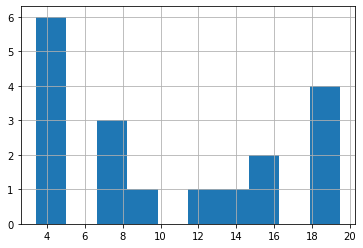

In [184]:
mdf['PFCF'].loc[mdf['PFCF'] < 20].hist()